参考文献：扩散模型从原理到实战

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else"cpu")
print(f'Using device: {device}')

Using device: cpu


In [2]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)
train_dataloader = DataLoader(dataset,batch_size=8,shuffle=True)
x, y = next(iter(train_dataloader))

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 5, 0, 0, 5, 1, 9, 0])


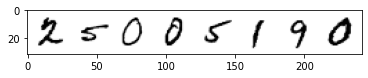

In [3]:
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

In [4]:
# amount = 0.4

# noise = torch.rand_like(x)
# noisy_x = (1-amount)*x + amount*noise
# plt.imshow(torchvision.utils.make_grid(noisy_x)[0], cmap='Greys')

In [5]:
x.shape

torch.Size([8, 1, 28, 28])

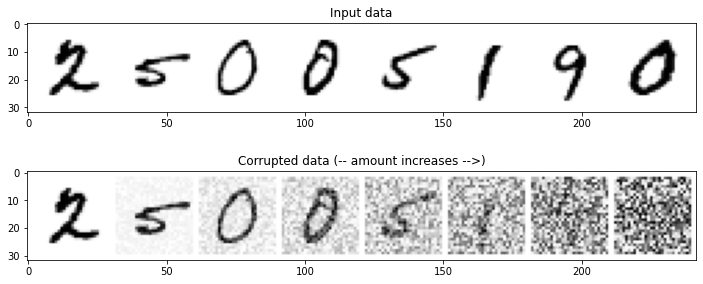

In [6]:
def corrupt(x, amount):
    """根据amount为输入x加入噪声，这就是退化过程"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # 整理形状以保证广播机制不出错
    return x*(1-amount) + noise*amount

# 绘制输入数据
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
# 加入噪声
amount = torch.linspace(0, 1, x.shape[0]) # 从0到1 → 退化更强烈了
noised_x = corrupt(x, amount)
# 绘制加噪版本的图像
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0],cmap='Greys')

In [43]:
model = UNet2DModel(
    sample_size=28, # 目标图像的分辨率
    in_channels=1, # 输入图像的通道数，RGB图像的通道数为3
    out_channels=1, # 输出图像的通道数
    layers_per_block=2, # 设置要在每一个UNet块中使用多少个ResNet层
    block_out_channels=(32, 64, 64), # 与BasicUNet模型的配置基本相同
    down_block_types=(
        "DownBlock2D", # 标准的ResNet下采样模块
        "AttnDownBlock2D", # 带有空域维度self-att的ResNet下采样模块
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D", # 带有空域维度self-att的ResNet上采样模块
        "UpBlock2D", # 标准的ResNet上采样模块
    ),
)
# 输出模型结构（看起来虽然冗长，但非常清晰）
# print(model)

In [48]:
model.forward?

In [7]:
class BasicUNet(nn.Module):
    """一个十分简单的UNet网络部署"""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5,
            padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5,
            padding=2),
        ])
        self.act = nn.ReLU() # 激活函数
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x)) # 通过运算层与激活函数
            if i < 2: # 选择除了第3层（最后一层）以外的层
                h.append(x) # 排列供残差连接使用的数据
                x = self.downscale(x)# 进行下采样以适配下一层的输入
        for i, l in enumerate(self.up_layers):
            if i > 0: # 选择除了第1个上采样层以外的层
                x = self.upscale(x)# Upscale上采样
                x += h.pop() # 得到之前排列好的供残差连接使用的数据
            x = self.act(l(x)) # 通过运算层与激活函数
        return x

In [8]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
x_ = net(x)
x_.shape
# 代码输出内容如下：

torch.Size([8, 1, 28, 28])

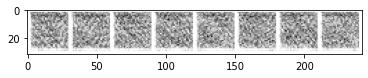

In [9]:
plt.imshow(torchvision.utils.make_grid(x_)[0], cmap='Greys')

In [44]:
# 数据加载器（你可以调整batch_size）
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
# 设置我们将在整个数据集上运行多少个周期
n_epochs = 3
# 创建网络
net = model # BasicUNet()
net.to(device)
# 指定损失函数
loss_fn = nn.MSELoss()
# 指定优化器
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
# 记录训练过程中的损失，供后期查看

In [47]:
losses = []
# 训练
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        # 得到数据并准备退化
        x = x.to(device) # 将数据加载到GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # 随机选取
        # 噪声量
        noisy_x = corrupt(x, noise_amount) # 创建“带噪”的输入
        noisy_x
        # 得到模型的预测结果
        pred = net(noisy_x, timestep = 0)# net(noisy_x)
        # 计算损失函数
        loss = loss_fn(pred, x) # 输出与真实“干净”的x有多接近？
        # 反向传播并更新参数
        opt.zero_grad()
        loss.backward()
        opt.step()
        # 存储损失，供后期查看
        losses.append(loss.item())
    # 输出在每个周期训练得到的损失的均值
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for thisepoch:{avg_loss:05f}')
    # 查看损失曲线
plt.plot(losses)
plt.ylim(0, 0.1);

AttributeError: 'UNet2DOutput' object has no attribute 'size'

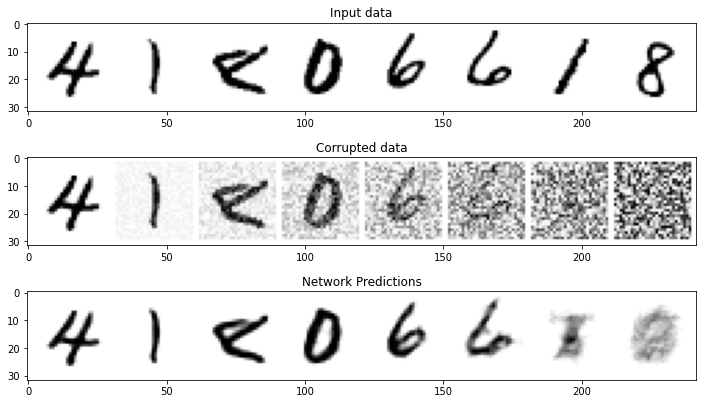

In [34]:
# 可视化模型在“带噪”输入上的表现
# 得到一些数据
x, y = next(iter(train_dataloader))
x = x[:8] # 为了便于展示，只选取前8条数据
# 在（0，1）区间选择退化量
amount = torch.linspace(0, 1, x.shape[0]) # 从0到1→退化更强烈了
noised_x = corrupt(x, amount)
# 得到模型的预测结果
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()
# 绘图
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1),cmap='Greys')

axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0,1),cmap='Greys')

axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1),cmap='Greys')

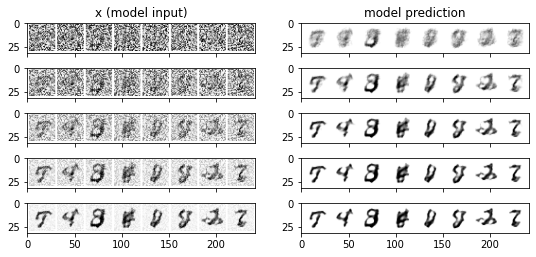

In [36]:
# 采样策略：把采样过程拆解为5步，每次只前进一步
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device) # 从完全随机的值开始
step_history = [x.detach().cpu()]
pred_output_history = []
for i in range(n_steps):
    with torch.no_grad(): # 在推理时不需要考虑张量的导数
        pred = net(x) # 预测“去噪”后的图像
    pred_output_history.append(pred.detach().cpu())
    # 将模型的输出保存下来，以便后续绘图时使用
    mix_factor = 1/(n_steps - i) # 设置朝着预测方向移动多少
    x = x*(1-mix_factor) + pred*mix_factor # 移动过程
    step_history.append(x.detach().cpu()) # 记录每一次移动，以便后续
# 绘图时使用
fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4),sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i,0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

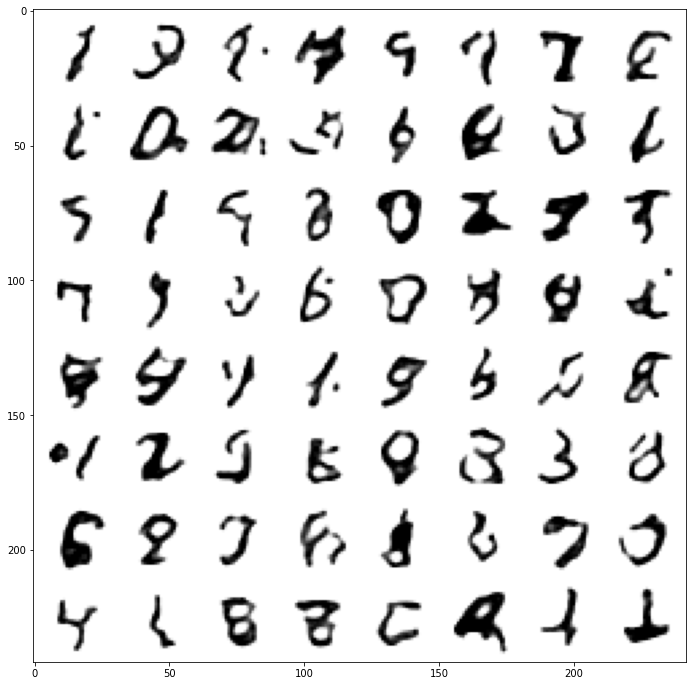

In [37]:
# 将采样过程拆解成40步
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1-(i/n_steps))# 将噪声量从高到低移动
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D

In [39]:
sum([p.numel() for p in model.parameters()])

1707009